<a href="https://colab.research.google.com/github/sandrynat/Transfer-Learning-ResNet-Keras/blob/main/AD2324_P6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup, Version check and Common imports

# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, 5)


# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras import layers

# to make this notebook's output stable across runs
np.random.seed(42)

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
#### Task 1 ####

# Using a pretrained neural network directly from Keras Applications to Classify Individual Images
# https://keras.io/api/applications/

# The ResNet-50 Model will be used to predict the category of selected images
# https://keras.io/api/applications/resnet/#resnet50-function

# Load Model with weights trained on Imagenet
modelR = tf.keras.applications.ResNet50(weights="imagenet")



102967424/102967424 [==============================] - 0s 0us/step


In [6]:
# Load two sample images and resize them to match the input required by ResNet

from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True)(images)
print(len(images_resized))


2


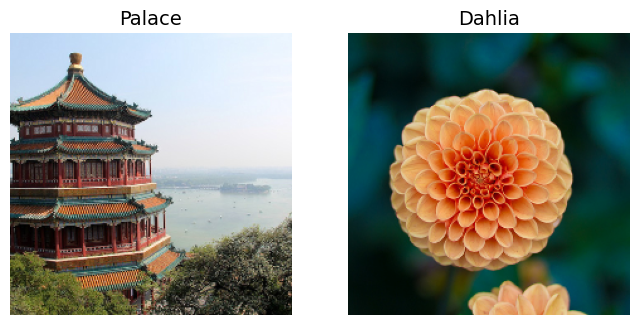

In [4]:
# Print the images

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(images_resized[0]/255.0)
plt.title('Palace')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Dahlia')
plt.imshow(images_resized[1]/255.0)
plt.axis('off')

plt.show()




In [7]:
# Preprocess the sample images in a specific way that the model is expecting
# Call method: resnet.preprocess_input()

inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)



In [8]:
# Make prediction with the pretrained model

Y_proba = modelR.predict(inputs)

print('Shape: ', Y_proba.shape)

print('First Prediction: ', Y_proba[0])



1/1 [==============================] - 3s 3s/step
Shape:  (2, 1000)
First Prediction:  [6.88575241e-09 5.67617029e-08 2.55749413e-08 2.53715937e-09
 1.45778332e-08 1.18202081e-07 6.99134333e-08 4.64526693e-08
 1.23410064e-08 1.91013626e-07 7.26155633e-07 1.86427457e-07
 7.16725708e-07 1.88341531e-07 1.34855986e-06 1.12924033e-06
 7.13120016e-08 1.49850780e-06 4.30782279e-07 4.34298869e-07
 9.27892074e-08 2.26617285e-08 5.95752248e-08 3.33869622e-07
 3.05352010e-08 3.39074568e-09 5.74844661e-09 8.46546921e-09
 1.77565820e-08 4.87908070e-09 1.72072507e-08 2.73495537e-08
 2.89956308e-08 1.68490235e-08 2.63587090e-08 1.99957402e-08
 7.92051047e-09 1.02792699e-08 1.39365834e-08 7.70337465e-08
 1.34572939e-08 6.59635120e-08 3.86675136e-09 1.19838077e-08
 3.37969972e-08 1.29259403e-08 9.64641078e-09 1.41541847e-07
 8.50539306e-10 2.75718914e-08 2.62959894e-08 1.97824708e-08
 2.63509659e-08 1.62058669e-08 4.29313607e-09 1.14883933e-08
 1.77523169e-08 1.44240540e-08 1.74909314e-08 1.65036056e-0

In [9]:
# Raw predictions are hard to understand
# Check the top predicted classes

top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")


35363/35363 [==============================] - 0s 0us/step
Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.71%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.67%
  n11939491 - daisy        17.82%
  n03530642 - honeycomb    12.04%


Are the results correct? How do you interpret the outcomes?

**Interpretação:**

Para a imagem#0, dentro do top 3 se identifica que o modelo reconheceu corretamente que a imagem corresponde à clase "palace" mas com uma probabilidade baixa (54.69%).
Em relação à imagem#1 o modelo não reconheceu no top 3 a clase adequada.


In [10]:
#### Task 2 ####

# Transfer Learning using Pretrained Neural Networks
# The same model ResNet-50 will be applied to the Flowers Dataset

# Data Fetching and Loading

import os
import pathlib

_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
path_to_zip = tf.keras.utils.get_file('flower_photos', origin=_URL, untar=True, cache_dir=os.curdir)
PATH = os.path.join(os.path.dirname(path_to_zip), 'flower_photos')
data_dir = pathlib.Path(PATH)

batch_size = 32


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  batch_size=batch_size)

class_names = train_ds.class_names

228813984/228813984 [==============================] - 2s 0us/step
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
# Load ResNet50 from Keras Applications

ResNet_base = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

ResNet_base.trainable = False # freeze

**Quiz 1**

Explain the meaning of the following code snippets and justify why they are relevant for this transfer learning task:


1.   include_top = False
**Argumento da função ResNet50() que especifica se vai ser usada ou não a última camada de classificação, neste caso é configurada em False, porque é preciso definir a camada de classificação adaptada a este problema cujo dataset (flowers) contém 5 clases**

2.   ResNet_base.trainable = False
**Atributo do objeto que especifica se os pesos da rede pretreinada vão ser no-trainable ou treinable. Neste caso foi colocada a False e basicamente fazemos um freeze ao pesos (no-trainable)**



In [13]:

# Create the complete model
# Adjust Image Size from (256, 256, 3) to (224, 224, 3)
# Preprocess the images to meet what is expected by ResNet
# Add GlobalAveragePooling + Classification Head

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(256, 256, 3))

x = layers.Lambda(lambda image: tf.image.resize(image, (224,224)))(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = ResNet_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(5, activation='softmax')(x)


model_TL1 = tf.keras.Model(inputs, outputs)


**Quiz 2:**

1.   Detail the changes that are performed to the images by the method preprocess_input()
**As imagens são convertidas do formato RGB ao BGR, também é feito o processo de zero-centering que básicamente desplaza os valores dos pixeis de tal forma que a media (mean) seja 0**

2.   How many weights has the feature extraction sub-model?
**23587712**



In [14]:
model_TL1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [15]:
# Model Compilation

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

model_TL1.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [16]:
# Training (Preferably with a GPU)

history = model_TL1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
)

Epoch 1/15
92/92 [==============================] - 25s 186ms/step - loss: 0.8872 - accuracy: 0.6710 - val_loss: 0.3801 - val_accuracy: 0.8556
Epoch 2/15
92/92 [==============================] - 13s 138ms/step - loss: 0.3893 - accuracy: 0.8614 - val_loss: 0.2914 - val_accuracy: 0.8924
Epoch 3/15
92/92 [==============================] - 16s 164ms/step - loss: 0.3021 - accuracy: 0.8978 - val_loss: 0.2504 - val_accuracy: 0.9074
Epoch 4/15
92/92 [==============================] - 13s 135ms/step - loss: 0.2385 - accuracy: 0.9131 - val_loss: 0.2333 - val_accuracy: 0.9101
Epoch 5/15
92/92 [==============================] - 13s 133ms/step - loss: 0.2009 - accuracy: 0.9339 - val_loss: 0.2166 - val_accuracy: 0.9169
Epoch 6/15
92/92 [==============================] - 13s 134ms/step - loss: 0.1728 - accuracy: 0.9424 - val_loss: 0.2220 - val_accuracy: 0.9210
Epoch 7/15
92/92 [==============================] - 13s 133ms/step - loss: 0.1439 - accuracy: 0.9557 - val_loss: 0.2104 - val_accuracy: 0.9251

<Axes: >

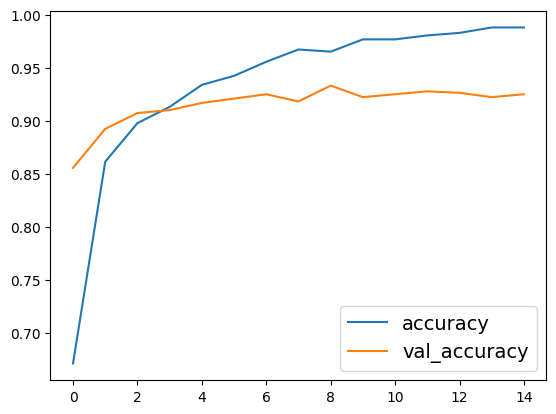

In [17]:
# Visualization of Results

import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()


Analyze results. By looking at the chart, what do you think is happening?

**A rede conseguiu obter uma boa accuracy logo na segunda epoch, mas comezou a ter overfitting a partir da epoch 12.**


In [18]:
# Top layers are well-trained and now we can unfreeze the weights of the base

ResNet_base.trainable = True

# Compile again

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

model_TL1.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [19]:
model_TL1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [20]:
# Resume training.
# It will take a while, even with a GPU. That's why we define a low number of training epochs

history = model_TL1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)

Epoch 1/5
92/92 [==============================] - 74s 432ms/step - loss: 0.3760 - accuracy: 0.8644 - val_loss: 0.3482 - val_accuracy: 0.8856
Epoch 2/5
92/92 [==============================] - 35s 380ms/step - loss: 0.3040 - accuracy: 0.8924 - val_loss: 0.2670 - val_accuracy: 0.8883
Epoch 3/5
92/92 [==============================] - 35s 382ms/step - loss: 0.2723 - accuracy: 0.9036 - val_loss: 0.3228 - val_accuracy: 0.8883
Epoch 4/5
92/92 [==============================] - 35s 378ms/step - loss: 0.2946 - accuracy: 0.9016 - val_loss: 0.3933 - val_accuracy: 0.8651
Epoch 5/5
92/92 [==============================] - 36s 390ms/step - loss: 0.3901 - accuracy: 0.8753 - val_loss: 0.6206 - val_accuracy: 0.7738


<Axes: >

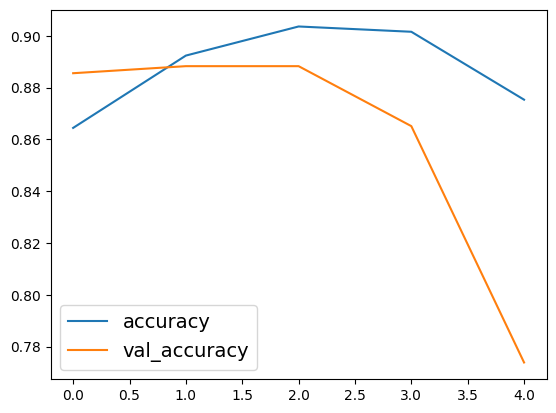

In [21]:
# Visualization of Results

import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [22]:
#### Task 3 ####

# Transfer Learning using anotgher Pretrained Neural Network
# The model Xception will be applied to the Flowers Dataset https://keras.io/api/applications/xception/

# Retrieve the original Xception model
# Complete the neural network (don't forget preprocessing)
# Train

### Code goes here
# Load Xception from Keras Applications

Xception_base = keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(224,224,3))
Xception_base.trainable = True
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(256, 256, 3))

x = layers.Lambda(lambda image: tf.image.resize(image, (224,224)))(inputs)
x = keras.applications.xception.preprocess_input(x)
x = Xception_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(5, activation='softmax')(x)


model_TL3 = tf.keras.Model(inputs, outputs)
model_TL3.summary()
# Model Compilation

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

model_TL3.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
# Training (Preferably with a GPU)

history = model_TL3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)



83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                              

<Axes: >

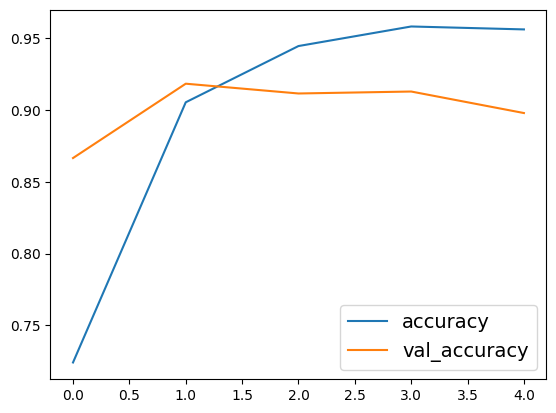

In [23]:
# Visualization of Results

import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

**Quiz 3**

Present the complete model that was created for the flowers dataset.
This model must rely on the Xception network to perform feature extraction.

**Foi comprovado que Xception tem melhor desempenho a comparação de RestNet50 baixo o esquema de fine-tuning**
